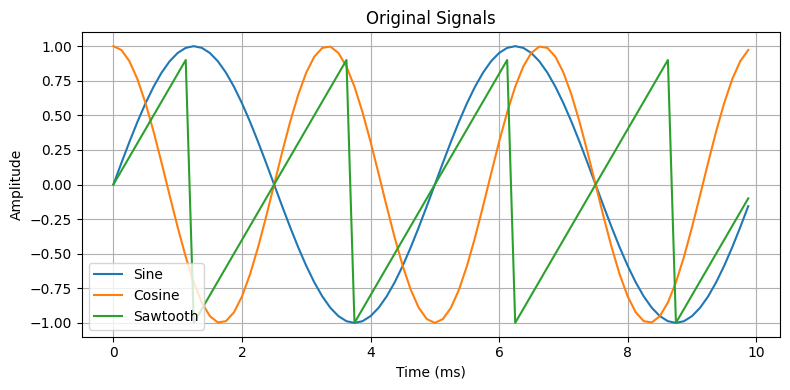

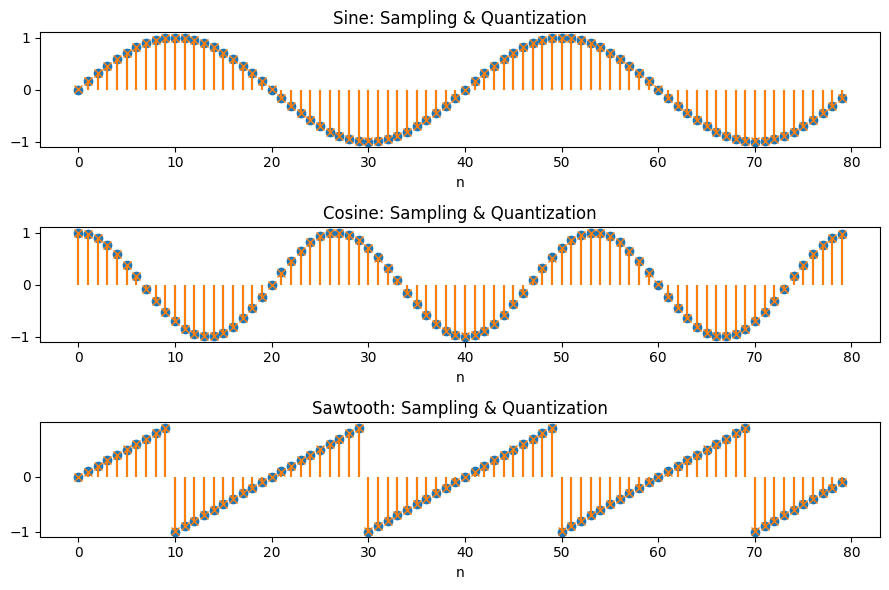

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Basic parameters
fs = 8000
Ts = 1/fs                 # 125 microseconds
duration = 0.01
N = int(fs * duration)
t = np.linspace(0, duration, N, endpoint=False)

# Signals
f1, f2, f3 = 200, 300, 400
sine = np.sin(2*np.pi*f1*t)
cosine = np.cos(2*np.pi*f2*t)
sawtooth = 2 * (t*f3 - np.floor(0.5 + t*f3))

# Uniform 8-bit quantizer
L = 256
nbits = 8
xmin, xmax = -1, 1
delta = (xmax - xmin) / L

def quantize(x):
    x = np.clip(x, xmin, xmax-1e-12)
    k = np.floor((x - xmin) / delta).astype(int)
    xq = xmin + (k + 0.5)*delta
    return k, xq

k1, q1 = quantize(sine)
k2, q2 = quantize(cosine)
k3, q3 = quantize(sawtooth)

# PCM encode
def pcm_encode(idx, nbits=8):
    fmt = f"0{nbits}b"
    return np.array([[int(b) for b in format(int(k), fmt)] for k in idx], dtype=int)

bits1 = pcm_encode(k1)
bits2 = pcm_encode(k2)
bits3 = pcm_encode(k3)

# ---- Plots: original signals ----
plt.figure(figsize=(8,4))
plt.plot(t*1000, sine, label='Sine')
plt.plot(t*1000, cosine, label='Cosine')
plt.plot(t*1000, sawtooth, label='Sawtooth')
plt.title("Original Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Sampling + Quantization plots ----
n = np.arange(N)
plt.figure(figsize=(9,6))

plt.subplot(3,1,1)
plt.stem(n, sine, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.stem(n, q1,   linefmt='C1-', markerfmt='C1x', basefmt=" ")
plt.title("Sine: Sampling & Quantization")
plt.xlabel("n")

plt.subplot(3,1,2)
plt.stem(n, cosine, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.stem(n, q2,     linefmt='C1-', markerfmt='C1x', basefmt=" ")
plt.title("Cosine: Sampling & Quantization")
plt.xlabel("n")

plt.subplot(3,1,3)
plt.stem(n, sawtooth, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.stem(n, q3,        linefmt='C1-', markerfmt='C1x', basefmt=" ")
plt.title("Sawtooth: Sampling & Quantization")
plt.xlabel("n")

plt.tight_layout()
plt.show()


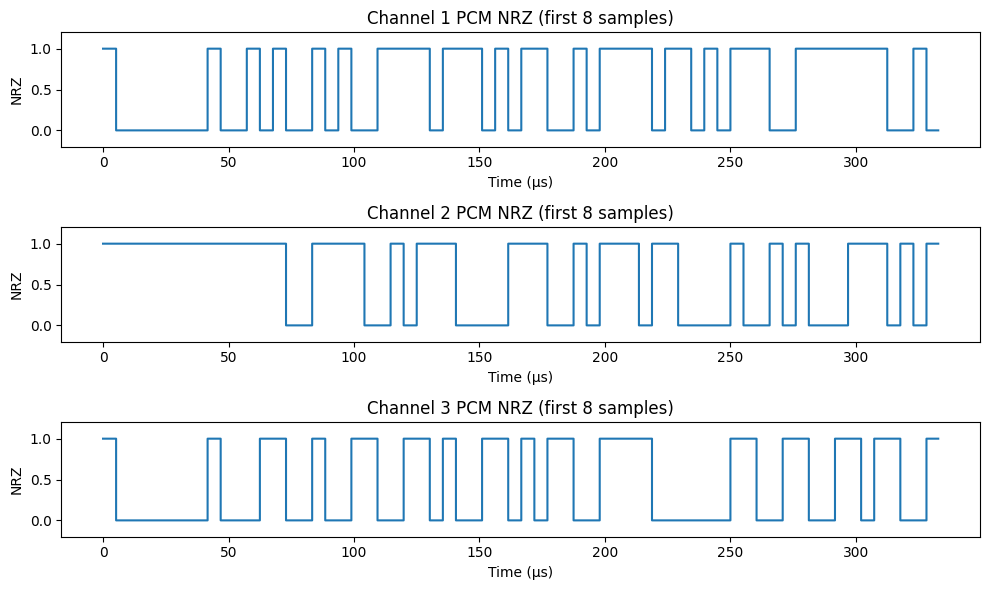

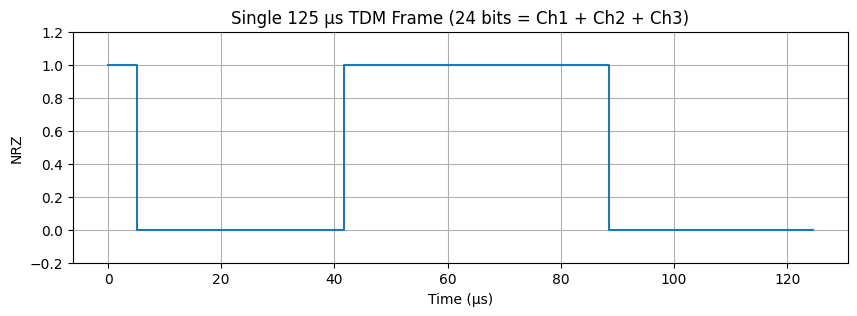

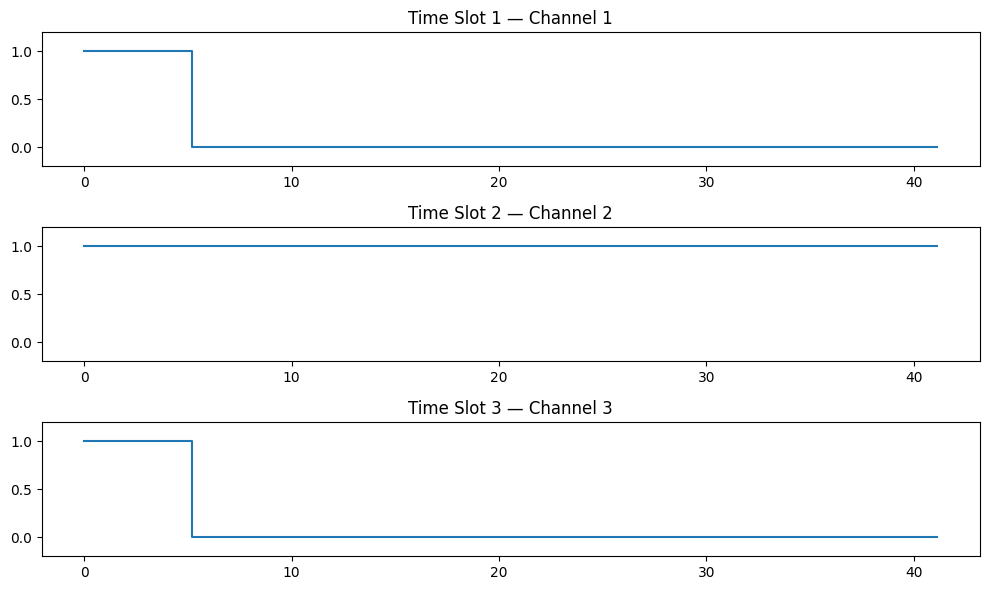

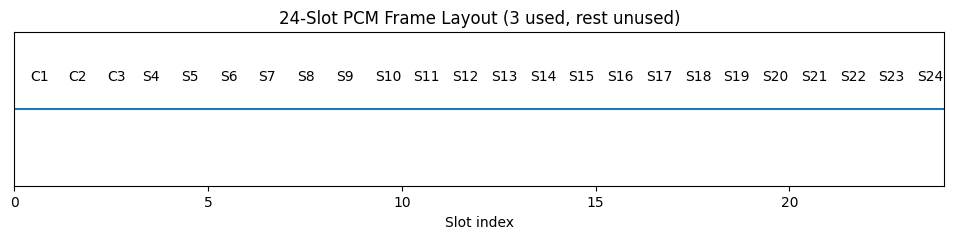

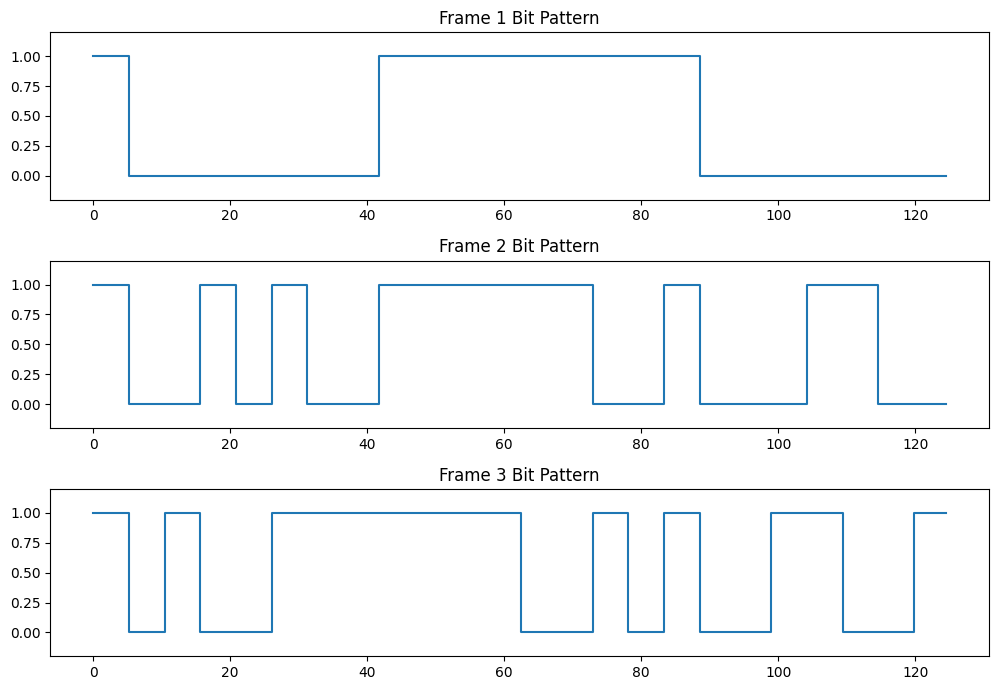

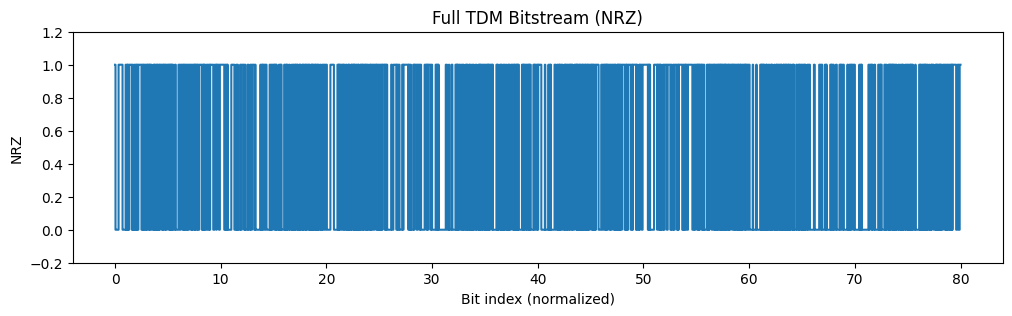

MSE (sine): 0.0
MSE (cosine): 0.0
MSE (sawtooth): 0.0


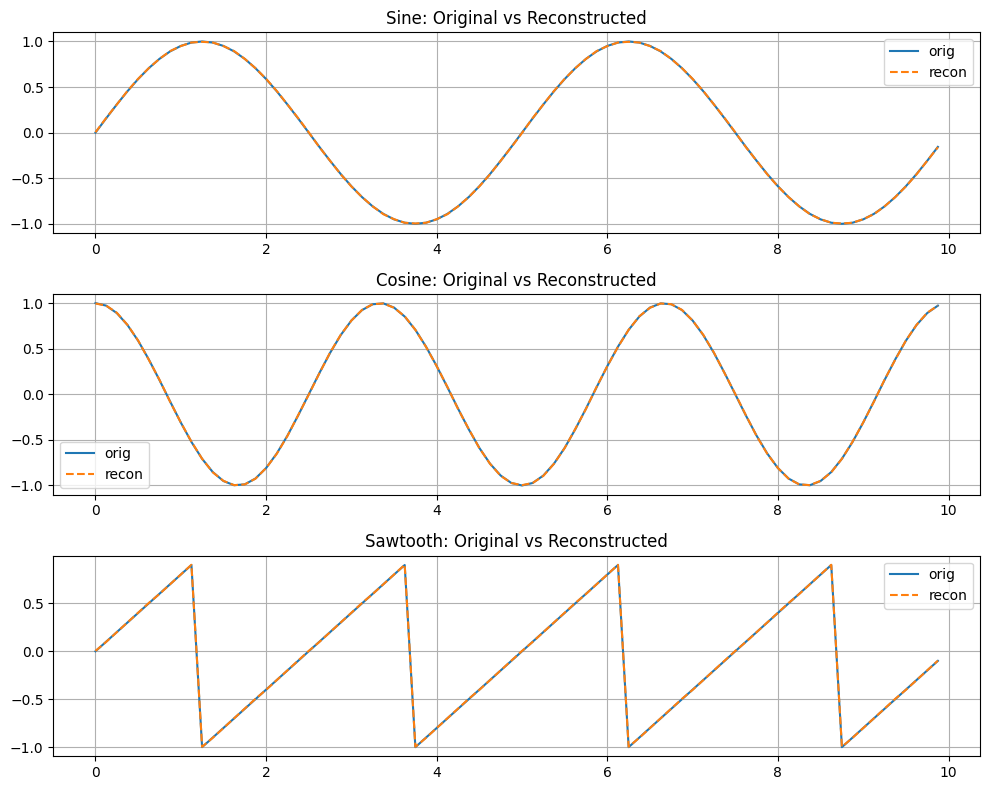

In [ ]:
# ---------------- TDM PARAMETERS ----------------
bits_per_sample = 8
channels = 3
bits_per_frame = bits_per_sample * channels   # 24 bits

# One frame = 125 microseconds → bit duration:
Tb = Ts / bits_per_frame     # = 125e-6 / 24

# Helper for NRZ conversion
def bits_to_nrz(bits, Tb, oversample=10):
    N = len(bits)
    t_local = np.linspace(0, N*Tb, N*oversample, endpoint=False)
    x = np.repeat(bits, oversample)
    return t_local, x

# ---------------- Build TDM frames ----------------
frames = np.concatenate([bits1, bits2, bits3], axis=1)   # shape (N, 24)
tdm_bits = frames.flatten()

# ---------------- NRZ for all 3 channels (first 8 samples) ----------------
samples_view = 8
ch1_bits_view = bits1[:samples_view].flatten()
ch2_bits_view = bits2[:samples_view].flatten()
ch3_bits_view = bits3[:samples_view].flatten()

t_ch1, x_ch1 = bits_to_nrz(ch1_bits_view, Tb)
t_ch2, x_ch2 = bits_to_nrz(ch2_bits_view, Tb)
t_ch3, x_ch3 = bits_to_nrz(ch3_bits_view, Tb)

# ---------------- Plot NRZ for 3 channels ----------------
plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.step(t_ch1*1e6, x_ch1, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Channel 1 PCM NRZ (first 8 samples)")
plt.xlabel("Time (µs)")
plt.ylabel("NRZ")

plt.subplot(3,1,2)
plt.step(t_ch2*1e6, x_ch2, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Channel 2 PCM NRZ (first 8 samples)")
plt.xlabel("Time (µs)")
plt.ylabel("NRZ")

plt.subplot(3,1,3)
plt.step(t_ch3*1e6, x_ch3, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Channel 3 PCM NRZ (first 8 samples)")
plt.xlabel("Time (µs)")
plt.ylabel("NRZ")

plt.tight_layout()
plt.show()

# ---------------- Show ONE 125µs TDM frame ----------------
frame0 = frames[0]  # first 24-bit frame
t_frame, x_frame = bits_to_nrz(frame0, Tb)

plt.figure(figsize=(10,3))
plt.step(t_frame*1e6, x_frame, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Single 125 µs TDM Frame (24 bits = Ch1 + Ch2 + Ch3)")
plt.xlabel("Time (µs)")
plt.ylabel("NRZ")
plt.grid(True)
plt.show()

# ---------------- Zoom 3 time slots ----------------
slot1 = frame0[:8]
slot2 = frame0[8:16]
slot3 = frame0[16:24]

t1, x1 = bits_to_nrz(slot1, Tb)
t2, x2 = bits_to_nrz(slot2, Tb)
t3, x3 = bits_to_nrz(slot3, Tb)

plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.step(t1*1e6, x1, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Time Slot 1 — Channel 1")

plt.subplot(3,1,2)
plt.step(t2*1e6, x2, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Time Slot 2 — Channel 2")

plt.subplot(3,1,3)
plt.step(t3*1e6, x3, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Time Slot 3 — Channel 3")

plt.tight_layout()
plt.show()

# ---------------- 24-slot frame layout (schematic) ----------------
plt.figure(figsize=(12,2))
for i in range(24):
    plt.hlines(1, i, i+1)
    if i < 3:
        plt.text(i+0.4, 1.02, f"C{i+1}")
    else:
        plt.text(i+0.3, 1.02, f"S{i+1}")
plt.title("24-Slot PCM Frame Layout (3 used, rest unused)")
plt.yticks([])
plt.xlabel("Slot index")
plt.xlim(0,24)
plt.show()

# ---------------- Bit pattern variation for 3 frames ----------------
frame1 = frames[0]
frame2 = frames[1]
frame3 = frames[2]

t1f, x1f = bits_to_nrz(frame1, Tb)
t2f, x2f = bits_to_nrz(frame2, Tb)
t3f, x3f = bits_to_nrz(frame3, Tb)

plt.figure(figsize=(10,7))

plt.subplot(3,1,1)
plt.step(t1f*1e6, x1f, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Frame 1 Bit Pattern")

plt.subplot(3,1,2)
plt.step(t2f*1e6, x2f, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Frame 2 Bit Pattern")

plt.subplot(3,1,3)
plt.step(t3f*1e6, x3f, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Frame 3 Bit Pattern")

plt.tight_layout()
plt.show()

# ---------------- Full TDM bitstream NRZ ----------------
t_tdm, x_tdm = bits_to_nrz(tdm_bits, Tb)

plt.figure(figsize=(12,3))
plt.step(t_tdm/Ts, x_tdm, where='post')
plt.ylim(-0.2, 1.2)
plt.title("Full TDM Bitstream (NRZ)")
plt.xlabel("Bit index (normalized)")
plt.ylabel("NRZ")
plt.show()

# ---------------- DEMULTIPLEX ----------------
frames_recv = tdm_bits.reshape(N, bits_per_frame)

bits1_r = frames_recv[:, :8]
bits2_r = frames_recv[:, 8:16]
bits3_r = frames_recv[:, 16:24]

def pcm_decode(bits_matrix):
    powers = 2 ** np.arange(bits_matrix.shape[1]-1, -1, -1)
    return bits_matrix @ powers

k1_rec = pcm_decode(bits1_r)
k2_rec = pcm_decode(bits2_r)
k3_rec = pcm_decode(bits3_r)

# ---------------- Dequantize ----------------
def dequantize(k):
    return xmin + (k + 0.5) * delta

rec1 = dequantize(k1_rec)
rec2 = dequantize(k2_rec)
rec3 = dequantize(k3_rec)

# ---------------- MSE ----------------
mse1 = np.mean((q1 - rec1)**2)
mse2 = np.mean((q2 - rec2)**2)
mse3 = np.mean((q3 - rec3)**2)

print("MSE (sine):", mse1)
print("MSE (cosine):", mse2)
print("MSE (sawtooth):", mse3)

# ---------------- Reconstruction plots ----------------
plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(t*1000, sine, label="orig")
plt.plot(t*1000, rec1, '--', label="recon")
plt.title("Sine: Original vs Reconstructed")
plt.legend(); plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t*1000, cosine, label="orig")
plt.plot(t*1000, rec2, '--', label="recon")
plt.title("Cosine: Original vs Reconstructed")
plt.legend(); plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t*1000, sawtooth, label="orig")
plt.plot(t*1000, rec3, '--', label="recon")
plt.title("Sawtooth: Original vs Reconstructed")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()
